In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
data = pd.read_csv("/Users/paxton615/GA/resource-datasets/\
sacramento_real_estate/Sacramentorealestatetransactions.csv")
df = pd.read_csv("/Users/paxton615/GA/resource-datasets/\
sacramento_real_estate/Sacramentorealestatetransactions.csv")
df.columns

Index(['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type',
       'sale_date', 'price', 'latitude', 'longitude'],
      dtype='object')

#### Conduct exploratory data analysis on this data set. 

In [13]:
df.describe()

,zip,beds,baths,sq__ft,price,latitude,longitude
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,95750.697462,2.911675,1.776650,1314.916751,234144.263959,38.607732,-121.355982
std,85.176072,1.307932,0.895371,853.048243,138365.839085,0.145433,0.138278
min,95603.000000,0.000000,0.000000,0.000000,1551.000000,38.241514,-121.551704
25%,95660.000000,2.000000,1.000000,952.000000,145000.000000,38.482717,-121.446127
50%,95762.000000,3.000000,2.000000,1304.000000,213750.000000,38.626582,-121.376220
75%,95828.000000,4.000000,2.000000,1718.000000,300000.000000,38.695589,-121.295778
max,95864.000000,8.000000,5.000000,5822.000000,884790.000000,39.020808,-120.597599


In [48]:
print(df[(df['baths']==0) | (df['sq__ft']==0) |( df['beds']==0)].shape)
print(df[(df['baths']==0) & (df['sq__ft']==0) &( df['beds']==0)].shape)
print(df[df['sq__ft']==0 ].shape)

(171, 13)
(108, 13)
(171, 13)


- sq_ft == 0 is not good for business
- except for this, everything else seems ok

#### Data Visualization

###### visualization before drop off some data

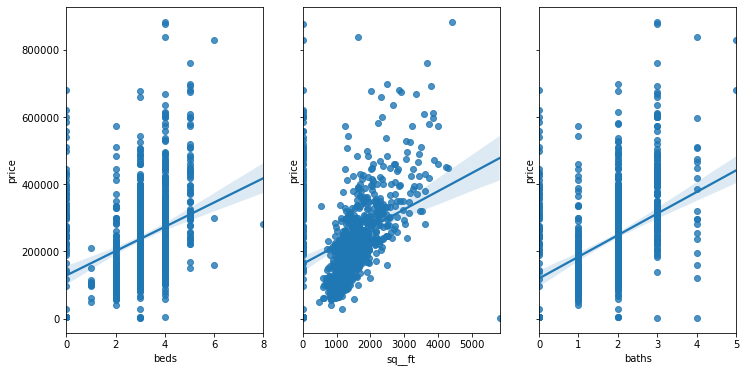

In [53]:
fig,ax = plt.subplots(1,3,figsize=(12,6), sharey=True)

ax[0] = sns.regplot(df['beds'], df['price'], ax=ax[0])
ax[1] = sns.regplot(df['sq__ft'], df['price'], ax=ax[1])
ax[2] = sns.regplot(df['baths'], df['price'], ax=ax[2])

plt.show()

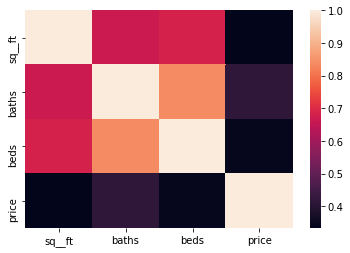

In [72]:
sns.heatmap(df[['sq__ft','baths','beds','price']].corr());

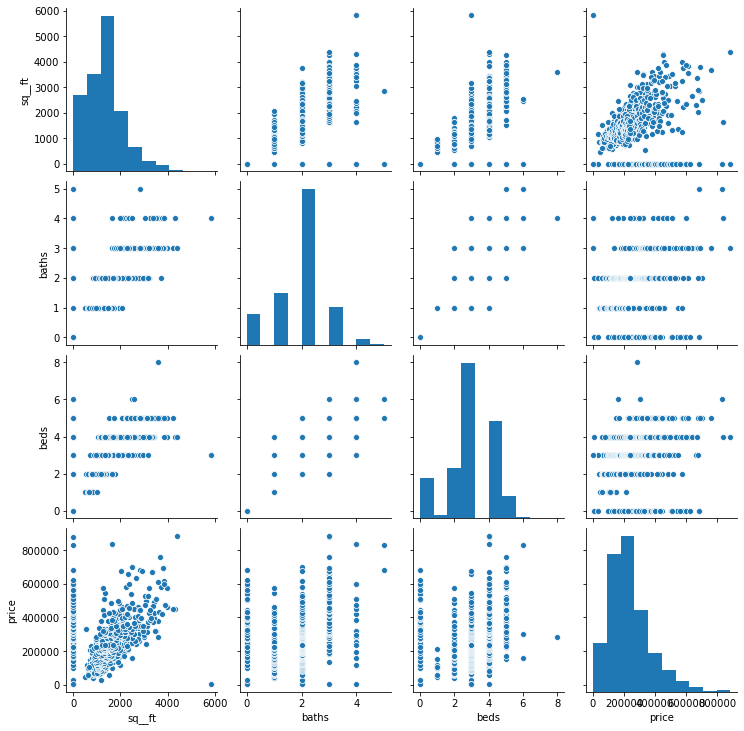

In [71]:
sns.pairplot(df, vars=df[['sq__ft','baths','beds','price']]);

###### visualization with clean data

In [73]:
df = df[df['sq__ft'] != 0]

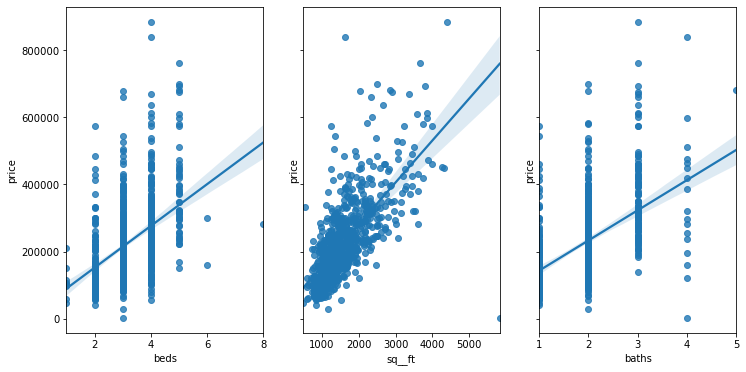

In [74]:
fig,ax = plt.subplots(1,3,figsize=(12,6), sharey=True)

ax[0] = sns.regplot(df['beds'], df['price'], ax=ax[0])
ax[1] = sns.regplot(df['sq__ft'], df['price'], ax=ax[1])
ax[2] = sns.regplot(df['baths'], df['price'], ax=ax[2])

plt.show()

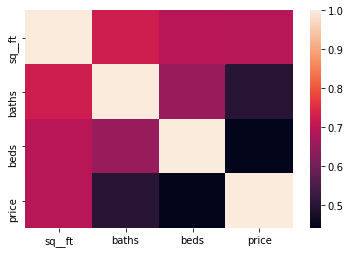

In [75]:
sns.heatmap(df[['sq__ft','baths','beds','price']].corr());

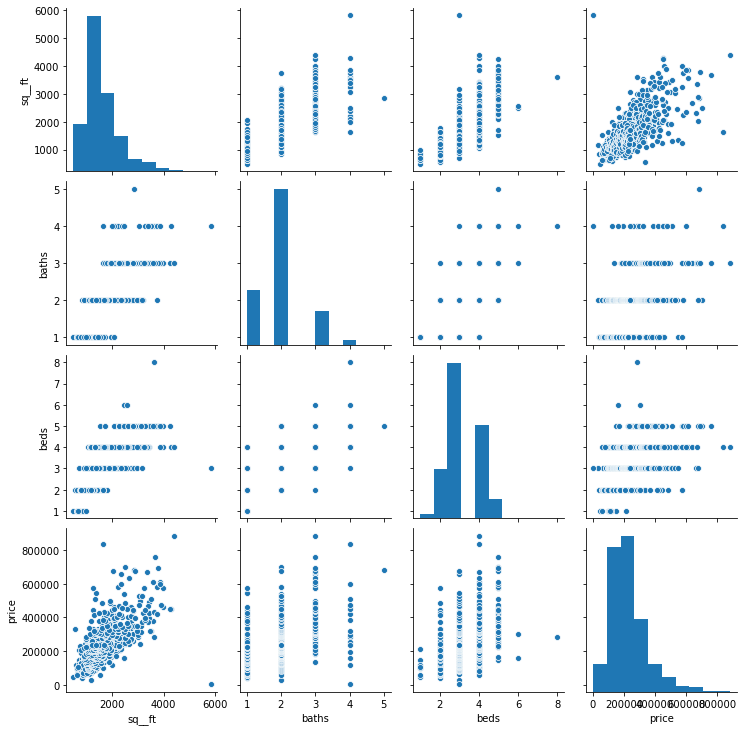

In [76]:
sns.pairplot(df, vars=df[['sq__ft','baths','beds','price']]);

- obviously, sq_ft should be choosing to predict the price
- one thing worth mentioning, heatmap says that baths is the most 
correlated one among 3 of them.

###### building regression

In [77]:
def sls_fit_pd(df, X, Y): 

    y_bar = df[Y].mean()
    x_bar = df[X].mean()
    std_y = df[Y].std()
    std_x = df[X].std()
    r_xy = df.corr().loc[X, Y]
    beta_1 = r_xy*(std_y/std_x)
    beta_0 = y_bar - beta_1*x_bar
    return beta_0, beta_1

In [79]:
sls_fit_pd(df, 'sq__ft', 'price')

(30210.633866919117, 125.21648667984451)

##### add prediction column and residuals column

In [82]:
beta0,beta1 = sls_fit_pd(df, 'sq__ft', 'price')
df['pred'] = beta0 + beta1*df['sq__ft']
df['residuals'] = df['price'] - df['pred']

In [86]:
df.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,pred,residuals
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,134891.616731,-75669.616731
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,176338.273822,-108126.273822
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,129882.957264,-61002.957264
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,136895.080518,-67588.080518
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,130008.173751,-48108.173751


In [94]:
print("mean residual:  {}".format(df.residuals.mean()))
print("MSE:  {}".format(df.residuals.map(lambda x:x**2).mean()))
print("RMSE:  {}".format(df.residuals.map(lambda x:x**2).mean()**0.5))

mean residual:  -1.2549686106036277e-11
MSE:  7439426337.103193
RMSE:  86252.10917480913


In [154]:
def calculate_r2(y, yhat):
    ss_res = np.sum((y - yhat)**2)  #rss
    ss_tot = np.sum((y-np.mean(y))**2)  #tss
    r2 = 1-ss_res/ss_tot
    return r2

print('r2_predictions: {}'.format(calculate_r2(df.price, df.pred)))
print('r2_mean_y: {}'.format(calculate_r2(df.price, df.price.mean())))

r2_predictions: 0.4812307133326902
r2_mean_y: 0.0


- 通过对比mean(y)，用R2分数给模型做个参考

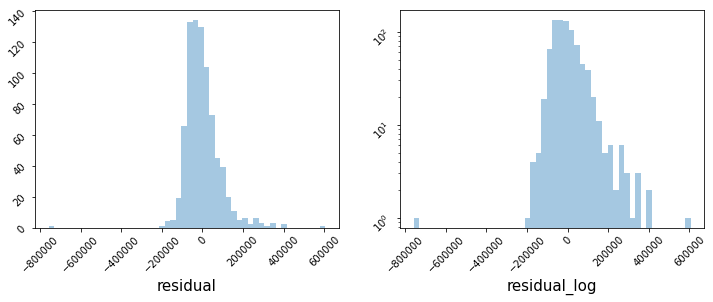

In [112]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0] = sns.distplot(df.residuals, bins=50, kde=False, ax=ax[0])
ax[0].tick_params(axis='both', rotation=45, labelsize=10)
ax[0].set_xlabel('residual', fontsize=15)



ax[1] = sns.distplot(df.residuals, bins=50, kde=False, ax=ax[1])
ax[1].tick_params(axis='both', rotation=45, labelsize=10)
ax[1].set_yscale('log')
ax[1].set_xlabel('residual_log', fontsize=15)

plt.show()


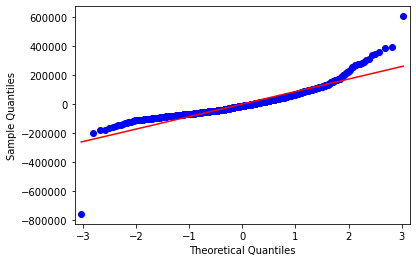

In [114]:
from statsmodels.graphics.gofplots import qqplot
qqplot(df.residuals, line='s');

- residuals为正态分布

In [141]:
x_values = np.linspace(df.sq__ft.min(), df.sq__ft.max(), 100)
y_values = beta0 + beta1*x_values

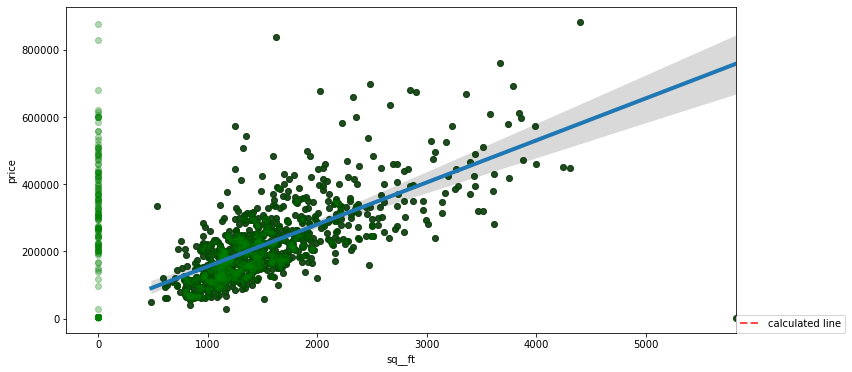

In [148]:
fig,ax = plt.subplots(figsize=(12,6))
sns.regplot(df['sq__ft'], df['price'], color='k') 
# plt.hist(df['sq__ft'])
plt.scatter(data.sq__ft, data.price, c='g',alpha=0.3)
plt.plot(df['sq__ft'], df['pred'], 'r--', alpha=0.7, lw=2, label='calculated line')
plt.plot(x_values, y_values, lw=4)
plt.legend(loc=[1, 0])

plt.show()

- 手动计算出的回归线，与sns画出的回归线完全重合。

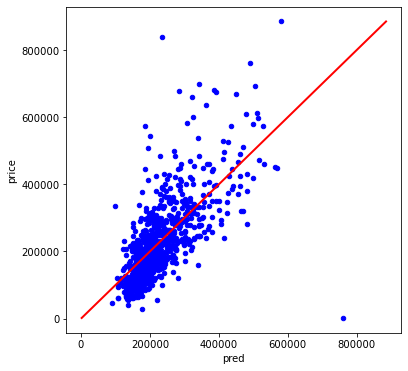

In [85]:
fig, ax = plt.subplots(figsize=(6, 6))
df.plot(x='pred', y='price', kind='scatter', color='b', ax=ax)
ax.plot([df.price.min(), df.price.max()], [
        df.price.min(), df.price.max()], lw=2, c='r')
plt.show()

- 红线为价格线，在价格线之上表明真实价格大于预测价格；在价格线之下，表示真实价格小于预测价格。非常有用！可以用来作为买方的价格指导。